In [1]:
!pip install yfinance

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b5b1f2488f4e11ff4d5681e32f7050860d4cecdef3a14156817dbecfdc4f58fb
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

📊 Evaluation Metrics for PLTR
RMSE: 4.7633
MAE: 3.5574
Direction Accuracy: 54.31%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

📈 Last Actual Close: $123.76
🔮 Predicted Next Close: $119.78


<ipython-input-7-5272b843ede6>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


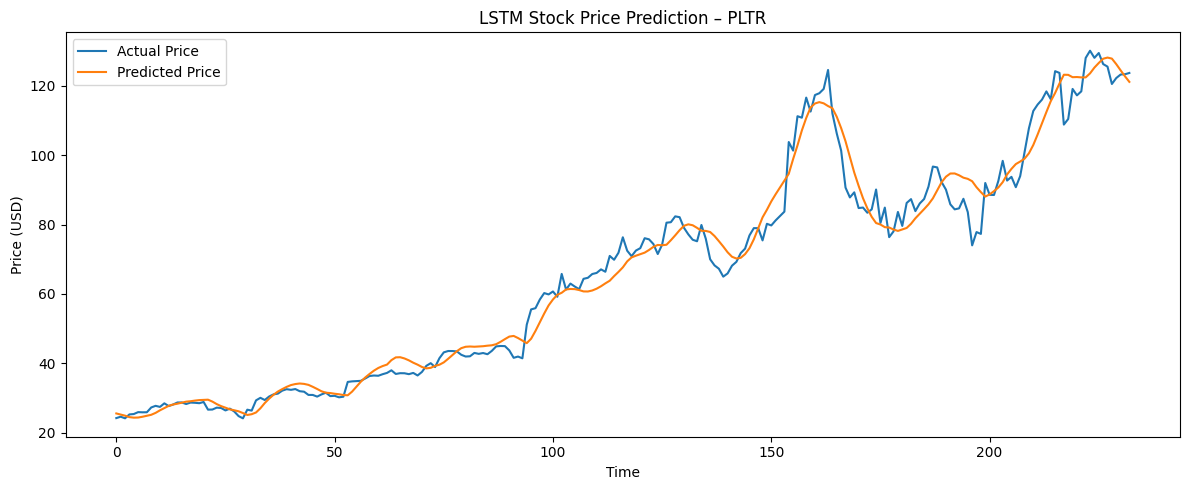

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

📆 5-Day Trading Forecast:


,Predicted_Close,Recommendation
Date,,
2025-05-29,119.78,SELL
2025-05-30,118.44,SELL
2025-06-02,117.23,SELL
2025-06-03,116.16,SELL
2025-06-04,115.24,SELL


In [7]:
#PLTR
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Stock Data ===
ticker = 'PLTR'
data = yf.download(ticker, start='2024-01-08', end='2025-05-29', interval='1d')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# === Step 3: Drop NA after indicators ===
data = data.dropna()

# === Step 4: Scale features ===
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 5: Create Sequences ===
lookback = 90
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# === Step 6: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=70, batch_size=32, verbose=0, callbacks=[es])

# === Step 7: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 8: Predict Next Day and Recommend Buy/Sell ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# === Step 9: Plot Prediction vs Actual ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Stock Price Prediction – {ticker}')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 10: Predict Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

# === Step 11: Format Trading Day Forecast ===
future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast:")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step

📊 Evaluation Metrics for UPST
RMSE: 4.8743
MAE: 3.6892
Direction Accuracy: 54.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

📈 Last Actual Close: $47.01
🔮 Predicted Next Close: $46.34


<ipython-input-6-9cb2dd64be69>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


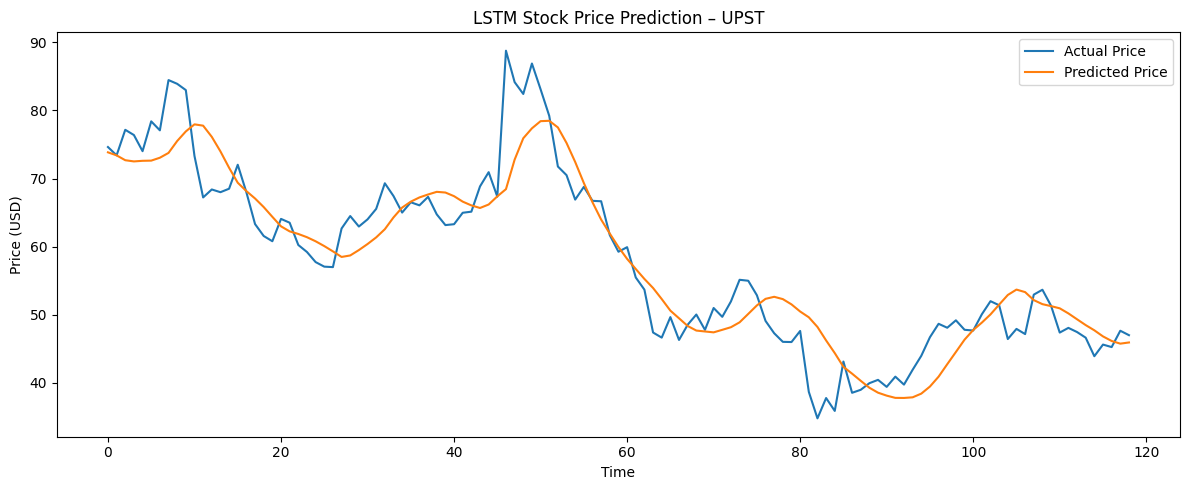

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

📆 5-Day Trading Forecast:


,Predicted_Close,Recommendation
Date,,
2025-05-29,46.34,SELL
2025-05-30,46.87,BUY
2025-06-02,47.49,BUY
2025-06-03,48.17,BUY
2025-06-04,48.86,BUY


In [6]:
# UPST
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Stock Data ===
ticker = 'UPST'
data = yf.download(ticker, start='2024-05-08', end='2025-05-29', interval='1d')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# === Step 3: Drop NA after indicators ===
data = data.dropna()

# === Step 4: Scale features ===
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 5: Create Sequences ===
lookback = 120
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# === Step 6: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=80, batch_size=32, verbose=0, callbacks=[es])

# === Step 7: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 8: Predict Next Day and Recommend Buy/Sell ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# === Step 9: Plot Prediction vs Actual ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Stock Price Prediction – {ticker}')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 10: Predict Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

# === Step 11: Format Trading Day Forecast ===
future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast:")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

📊 Evaluation Metrics for SOFI (Weekly Data)
RMSE: 0.9240
MAE: 0.7071
Direction Accuracy: 46.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


<ipython-input-8-f8d5cce8ae1b>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])



📈 Last Actual Close: $13.32
🔮 Predicted Next Close: $14.00


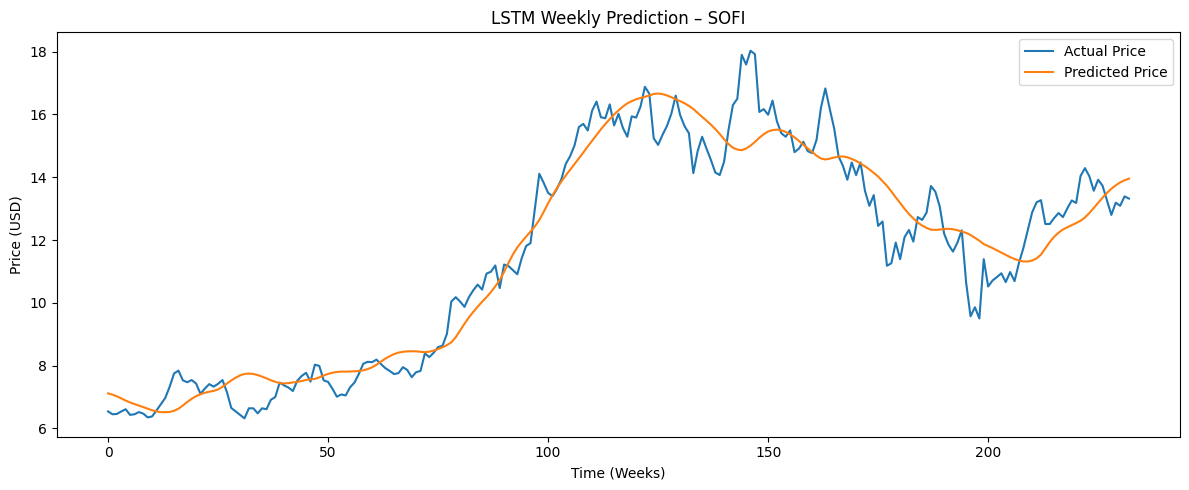

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

📆 5-Day Trading Forecast for SOFI:


,Predicted_Close,Recommendation
Date,,
2025-05-29,14.00,BUY
2025-05-30,14.04,BUY
2025-06-02,14.09,BUY
2025-06-03,14.14,BUY
2025-06-04,14.19,BUY


In [8]:
# SOFI
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Weekly Stock Data ===
ticker = 'SOFI'
data = yf.download(ticker, start='2024-01-08', end='2025-05-29', interval='1D')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()
data['MA_diff'] = data['EMA20'] - data['MA20']

# === Step 3: Drop NA and Scale Features ===
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume', 'MA_diff']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 4: Create Sequences ===
lookback = 90
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'
X = np.array(X)
y = np.array(y)

# === Step 5: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adamax', loss='huber')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=70, batch_size=32, verbose=0, callbacks=[es])

# === Step 6: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker} (Weekly Data)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 7: Predict Next Week and Recommend ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# === Step 8: Plot Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 9: Forecast Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast for SOFI:")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Evaluation Metrics for AI (Weekly Data)
RMSE: 2.2977
MAE: 1.6761
Direction Accuracy: 48.01%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-9-a446ce476bdf>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])



📈 Last Actual Close: $23.02
🔮 Predicted Next Close: $24.41


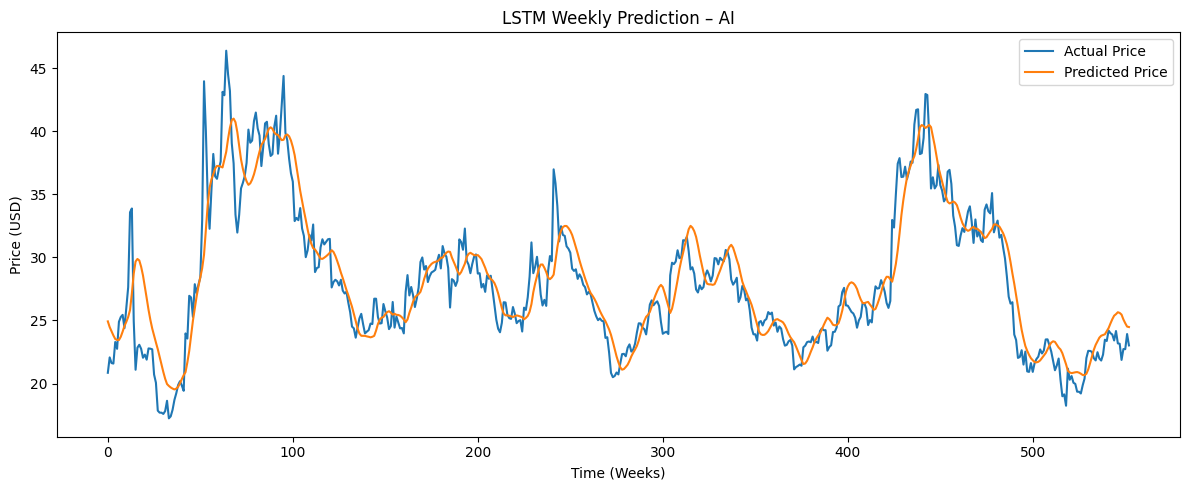

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

📆 5-Day Trading Forecast :


,Predicted_Close,Recommendation
Date,,
2025-05-29,24.41,BUY
2025-05-30,24.41,SELL
2025-06-02,24.44,BUY
2025-06-03,24.50,BUY
2025-06-04,24.56,BUY


In [9]:
# AI
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
from pandas.tseries.offsets import BDay
from IPython.display import display

# === Step 1: Download Weekly Stock Data ===
ticker = 'AI'
data = yf.download(ticker, start='2023-01-08', end='2025-05-29', interval='1D')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# === Step 2: Add Technical Indicators ===
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()
data['MA_diff'] = data['EMA20'] - data['MA20']

# === Step 3: Drop NA and Scale Features ===
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume', 'MA_diff']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === Step 4: Create Sequences ===
lookback = 20
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'
X = np.array(X)
y = np.array(y)

# === Step 5: Build and Train LSTM Model ===
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adamax', loss='huber')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=32, verbose=0, callbacks=[es])

# === Step 6: Predict and Evaluate ===
predicted = model.predict(X)
scaler_close = MinMaxScaler().fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))
last_close = float(data['Close'].values[-1])

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker} (Weekly Data)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# === Step 7: Predict Next Week and Recommend ===
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# === Step 8: Plot Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# === Step 9: Forecast Next 5 Trading Days ===
future_days = 5
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_days):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_day_scaled = sequence[-1].copy()
    next_day_scaled[0] = pred_scaled
    sequence.append(next_day_scaled)

future_dates = pd.bdate_range(start=data.index[-1] + BDay(1), periods=future_days)
recommendations = ['BUY' if future_predictions[0] > last_close else 'SELL']
recommendations += ['BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
                    for i in range(1, future_days)]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

print("\n📆 5-Day Trading Forecast :")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step

📊 Evaluation Metrics for TOL
RMSE: 9.0088
MAE: 7.7713
Direction Accuracy: 60.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


<ipython-input-11-3a30b7fa5ded>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])



📈 Last Actual Close: $104.18
🔮 Predicted Next Close: $97.35


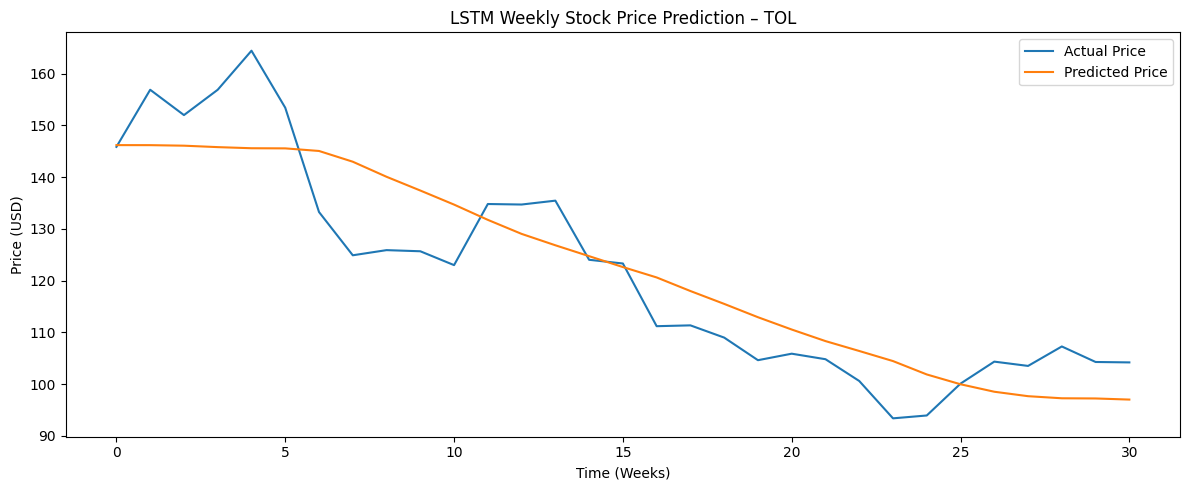

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

📆 Forecast for HRL


,Predicted_Close,Recommendation
Date,,
2025-06-04,97.3,SELL


In [11]:
# TOL

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'TOL'
data = yf.download(ticker, start='2023-05-08', end='2025-05-29', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 52
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=40, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Weeks
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-06-04'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(1)

#Show prediction
print("\n📆 Forecast for HRL")
display(forecast_df)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step

📊 Evaluation Metrics for HRL
RMSE: 0.9063
MAE: 0.6911
Direction Accuracy: 52.78%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

📈 Last Actual Close: $30.04
🔮 Predicted Next Close: $29.39


<ipython-input-12-32d13e072cc1>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


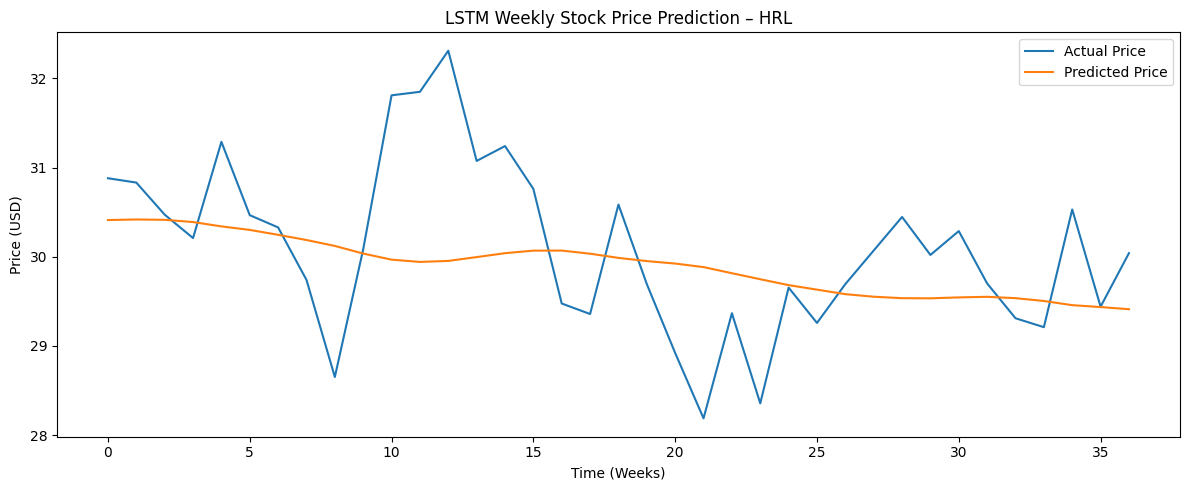

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

📆 Forecast for HRL


,Predicted_Close,Recommendation
Date,,
2025-06-04,29.4,SELL


In [12]:
# HRL
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'HRL'
data = yf.download(ticker, start='2023-05-08', end='2025-05-29', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20','Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 52
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=30, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Weeks
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-06-04'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(1)

#Show prediction
print("\n📆 Forecast for HRL")
display(forecast_df)



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step

📊 Evaluation Metrics for RHI
RMSE: 2.2166
MAE: 1.8026
Direction Accuracy: 68.18%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step

📈 Last Actual Close: $45.92
🔮 Predicted Next Close: $44.10


<ipython-input-13-0d6edc2a8a08>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


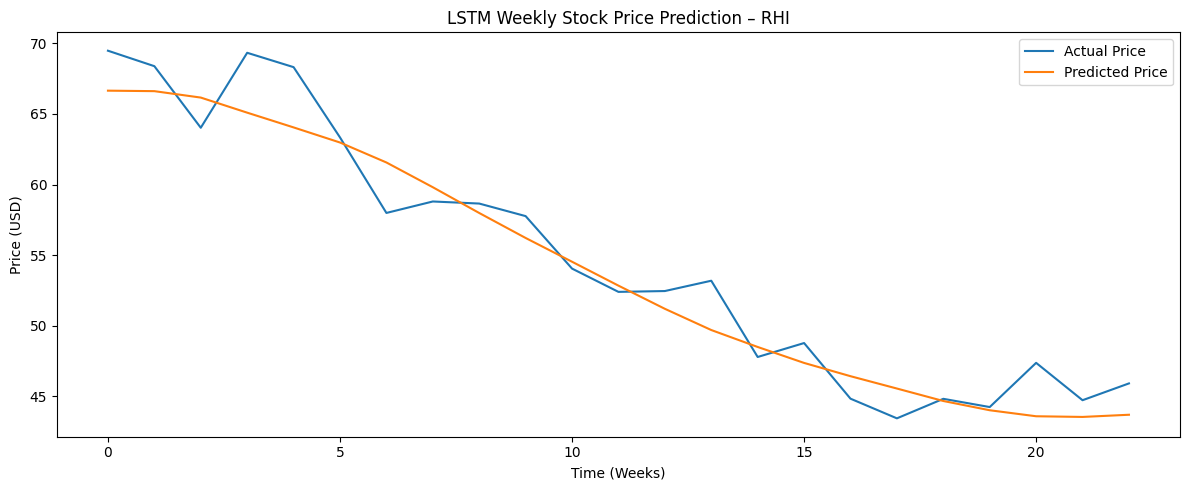

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

📆 Forecast for RHI


,Predicted_Close,Recommendation
Date,,
2025-06-04,44.1,SELL


In [13]:
# RHI

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'RHI'
data = yf.download(ticker, start='2023-05-08', end='2025-05-29', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20', 'RSI', 'MACD', 'Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=40, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Week
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-06-04'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

#Show prediction
print("\n📆 Forecast for RHI")
display(forecast_df)



[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step

📊 Evaluation Metrics for DTE
RMSE: 4.8040
MAE: 4.2824
Direction Accuracy: 54.17%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

📈 Last Actual Close: $134.98
🔮 Predicted Next Close: $134.52


<ipython-input-14-57856e2c3476>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(data['Close'].values[-1])


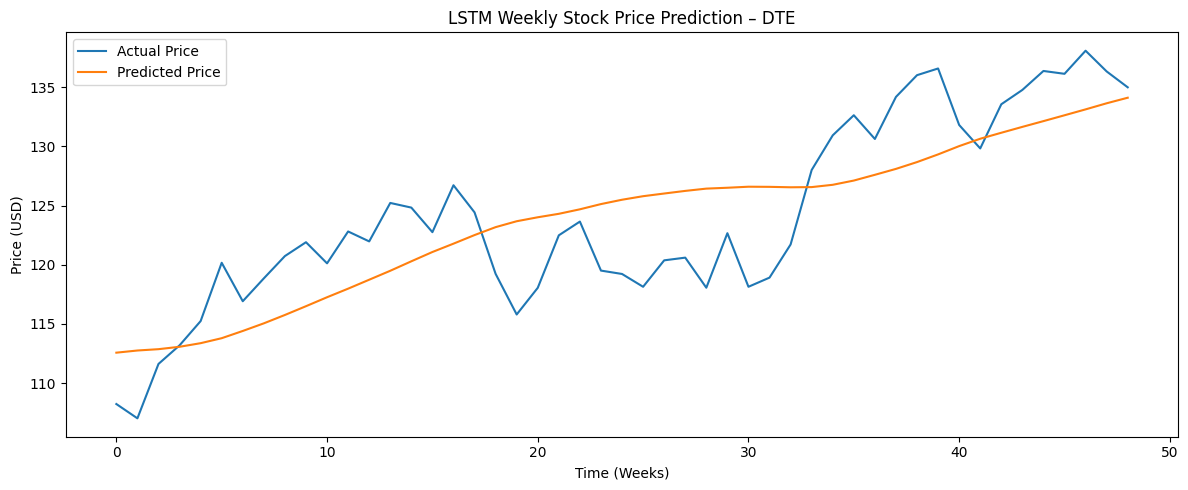

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

📆 Forecast for DTE


,Predicted_Close,Recommendation
Date,,
2025-06-04,134.52,SELL


In [14]:
# DTE

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import ta
from IPython.display import display
from keras.callbacks import EarlyStopping

# Step 1: Download Weekly Stock Data
ticker = 'DTE'
data = yf.download(ticker, start='2023-05-08', end='2025-05-29', interval='1wk')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Step 2: Add Technical Indicators
data['MA20'] = data['Close'].rolling(20).mean()
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Step 3: Drop NA & Select Features
data = data.dropna()
features = ['Close', 'MA20', 'EMA20','Volume']
scaled_data = MinMaxScaler().fit_transform(data[features])

# Step 4: Create Sequences
lookback = 40
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0])  # Predicting 'Close'

X = np.array(X)
y = np.array(y)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=25, batch_size=32, verbose=0, callbacks=[es])

# Step 6: Predict and Invert Scaling
predicted = model.predict(X)
scaler_close = MinMaxScaler()
scaler_close.fit(data[['Close']])
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y.reshape(-1, 1))

# Step 7: Evaluate Model
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
direction_accuracy = np.mean(
    np.sign(predicted_prices[1:] - predicted_prices[:-1]) ==
    np.sign(actual_prices[1:] - actual_prices[:-1])
)

print(f"\n📊 Evaluation Metrics for {ticker}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Direction Accuracy: {direction_accuracy:.2%}")

# Step 8: Recommend Buy or Sell (Next Week)
latest_data = scaled_data[-lookback:]
X_pred = latest_data.reshape(1, lookback, len(features))
next_scaled = model.predict(X_pred)
predicted_next_close = float(scaler_close.inverse_transform(next_scaled)[0][0])
last_close = float(data['Close'].values[-1])

print(f"\n📈 Last Actual Close: ${last_close:.2f}")
print(f"🔮 Predicted Next Close: ${predicted_next_close:.2f}")


# Step 9: Visualization of Predictions
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'LSTM Weekly Stock Price Prediction – {ticker}')
plt.xlabel('Time (Weeks)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 10: Forecast Next Week
future_weeks = 1
future_predictions = []
sequence = scaled_data[-lookback:].tolist()

for _ in range(future_weeks):
    X_future = np.array(sequence[-lookback:]).reshape(1, lookback, len(features))
    pred_scaled = model.predict(X_future)[0][0]
    pred_price = scaler_close.inverse_transform([[pred_scaled]])[0][0]
    future_predictions.append(pred_price)
    next_week_scaled = sequence[-1].copy()
    next_week_scaled[0] = pred_scaled
    sequence.append(next_week_scaled)

# ✅
future_dates = pd.to_datetime(['2025-06-04'])

recommendations = [
    'BUY' if future_predictions[0] > last_close else 'SELL'
] + [
    'BUY' if future_predictions[i] > future_predictions[i-1] else 'SELL'
    for i in range(1, future_weeks)
]

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions,
    'Recommendation': recommendations
})
forecast_df.set_index('Date', inplace=True)
forecast_df = forecast_df.round(2)

#Show prediction
print("\n📆 Forecast for DTE")
display(forecast_df)

